In [24]:
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, BatchNormalization, Dropout
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

%matplotlib inline
%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [87]:
sel_columns = [' Meas_5', ' Meas_6',' Meas_10']
v1 = pd.read_csv('example_data_new/v1_obfs.csv', usecols=sel_columns)
v2 = pd.read_csv('example_data_new/v2_obfs.csv', usecols=sel_columns)
v4 = pd.read_csv('example_data_new/v4_obfs.csv', usecols=sel_columns)
v = [v1, v2, v4]
v_names = ['v1', 'v2', 'v4']

### Functions

In [142]:
def sliding_window_2d(data, train_size, test_size, step_size):
    '''sliding window with an intersection between windows
    by size of _step_size_'''
    xy = []
    line_size = data.shape[1]
    for row in range(0, data.shape[0]):
        for start in range(0, line_size, step_size):
            stop =  start+train_size+test_size
            if stop <= line_size:
                xy.append(data[row, start: stop])
    return np.array(xy)


def xy_split(data, train_size):
    """split sliding windows into X and Y,
       input and output of the model.
    """
    x, y = data[:, :train_size], data[:, train_size:]
    return x, y


def norm_ts(data, transpose=True):
    """
    scaler ->  TS∈[0,1] .
    """
    scaler = MinMaxScaler(copy=True)
    if transpose:
        scaled01 = scaler.fit_transform(data.T).T
    else:
        scaled01 = scaler.fit_transform(data)
    return np.squeeze(scaled01), scaler


def inverse_norm(data, scaler):
    """ inverse scaling
    """
    return scaler.inverse_transform(data)


def train_test_reshape(train_x, test_x):
    """reshape + split train test 50-50"""
    return np.expand_dims(train_x, axis=2), np.expand_dims(test_x, axis=2)


def naive_prediction_mae(x_test, y_test):
    """prediction using last value"""
    naive_pred = 0
    n = x_test.shape[0]
    for i in range(n): 
        naive_pred += np.mean(np.abs(x_test[i, -1] - y_test[i, :]))
    naive_pred /= n
    print ('naive model = {0:0.4f}'.format(naive_pred))
    return None


def model_mae(model, x_test, y_test, scaler, inv_norm=False):
    """calculation MAE for prediction"""
    y_pred = model.predict(x_test)
    if inv_norm:
        y_pred=inverse_norm(y_pred.T, scaler).T
    mae = 0
    n = x_test.shape[0]
    for i in range(n): 
        mae += np.mean(np.abs(y_pred[i, :] - y_test[i, :]))
    mae /= n
    print ('current model = {0:0.4f}'.format(mae))
    return None


def model_mae_n(model, x_test, y_test, scaler, n, inv_norm=False):
    """calculation MAE for prediction"""
    y_pred = model.predict(x_test)
    if inv_norm:
        y_pred=inverse_norm(y_pred.T, scaler).T
    mae = 0
    for i in range(n): 
        mae += np.mean(np.abs(y_pred[i, :] - y_test[i, :]))
    mae /= n
    print ('current model = {0:0.4f}'.format(mae))
    return None


def scaler_merge(scalers):
    '''Given a list of MinMax scalers, returns 1 scaler
    which is a concatenation of multiple ones'''
    
    min_, scale_ = [], []
    for scaler in scalers:
        min_.append(scaler.min_)
        scale_.append(scaler.scale_)
    scalers[0].min_ = np.concatenate(min_)
    scalers[0].scale_ = np.concatenate(scale_)
    return scalers[0]
    
    


### Let's plot selected columns

In [97]:
# v_1_2_4.plot(figsize=(15,5), alpha=.4);
v_1_2_4[['v4_ Meas_5', 'v4_ Meas_6', 'v4_ Meas_6']][:720].plot(figsize=(15,5), alpha=.4);
v_1_2_4[['v2_ Meas_5', 'v2_ Meas_6', 'v2_ Meas_6']][:720].plot(figsize=(15,5), alpha=.4);

NameError: name 'v_1_2_4' is not defined

In [89]:
v_1_2_4.columns

NameError: name 'v_1_2_4' is not defined

In [98]:
v_1_2_4[:720].plot(figsize=(15,5), alpha=.6);

NameError: name 'v_1_2_4' is not defined

### Parameters of Sliding Window

In [143]:
train_size = 168
test_size = 24
train_test_size = train_size + test_size
line_size = v1.shape[1]
step_size = 1
train_vs_test = .75

### Normalization

In [144]:
def preprocessing(df, train_vs_test, train_size, test_size, step_size):
    '''Split data into windows + train + test'''
    data = df.values.T
    train_test_split = int(train_vs_test * data.shape[1])
    train_xy = data[:, :train_test_split]
    test_xy = data[:, train_test_split:]
    train_xy, scaler = norm_ts(train_xy)

    train_xy = sliding_window_2d(data=train_xy,
                                 train_size=train_size,
                                 test_size=test_size,
                                 step_size=step_size)

    test_xy = sliding_window_2d(data=test_xy,
                                train_size=train_size,
                                test_size=test_size,
                                step_size=step_size)
    
    test_x_original, test_y_original = xy_split(test_xy, train_size)
    test_x, scaler_test = norm_ts(test_x_original, transpose=True)
    train_x, train_y = xy_split(train_xy, train_size)
    
    return {'train_x': train_x, 
            'train_y': train_y,
            'test_x': test_x,
            'test_x_original': test_x_original,
            'test_y_original': test_y_original,
            'scaler_test': scaler_test}
           

def preporcess_multiple_df(dfs, train_vs_test, train_size, test_size, step_size):
    '''preforms preprocessing per list of DataFrames (input)'''
    res_dfs = defaultdict(list)
    for df in dfs:
        res_single_df = preprocessing(df, 
                                      train_vs_test,
                                      train_size,
                                      test_size,
                                      step_size)
        for key in res_single_df:
            res_dfs[key].append(res_single_df[key])
            
    train_x = np.concatenate(res_dfs['train_x'])
    train_y = np.concatenate(res_dfs['train_y'])
    test_x = np.concatenate(res_dfs['test_x'])
    test_x_original = np.concatenate(res_dfs['test_x_original'])
    test_y_original = np.concatenate(res_dfs['test_y_original'])
    scaler_test = scaler_merge(res_dfs['scaler_test'])
    train_x, test_x = train_test_reshape(train_x, test_x)
    return (train_x, train_y,
            test_x, 
            test_x_original, test_y_original, 
            scaler_test)
        
        
dfs = v
train_x, train_y, test_x, test_x_original, test_y_original, scaler_test = \
preporcess_multiple_df(dfs, train_vs_test, train_size, test_size, step_size)        


print (train_x.shape, train_y.shape, test_x.shape, test_y_original.shape)

(41631, 168, 1) (41631, 24) (12738, 168, 1) (12738, 24)


### CNN network

In [145]:

def cnn_model(x_train, y_train, batch_size, epochs=50, n_steps_for_train=train_size):
    
    
    input_dim = n_steps_for_train
    model = Sequential()
    model.add(Convolution1D(filters=6, kernel_size=4, input_shape=(input_dim ,1)))
    model.add(Flatten())
    model.add(Dense(units=64, kernel_initializer='normal'))
    # model.add(BatchNormalization())
    model.add(Activation('relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(units=60, actiivation='relu'))
    # model.add(Dense(units=40, activation='relu'))
    model.add(Dense(units=24, activation='linear'))


    sgd = optimizers.SGD(lr=0.1)
    model.compile(loss='mean_squared_error',
                  optimizer='sgd',
                  metrics=['mae'])

    history = model.fit(x_train, y_train, epochs=epochs, shuffle=True, batch_size=batch_size, validation_split=.3, verbose=2)
    return model, history

In [146]:
model, history = cnn_model(x_train=train_x, y_train=train_y, batch_size=4, epochs=20)

Train on 29141 samples, validate on 12490 samples
Epoch 1/20
 - 9s - loss: 0.0136 - mean_absolute_error: 0.0715 - val_loss: 0.0069 - val_mean_absolute_error: 0.0474
Epoch 2/20
 - 9s - loss: 0.0083 - mean_absolute_error: 0.0539 - val_loss: 0.0054 - val_mean_absolute_error: 0.0408
Epoch 3/20
 - 8s - loss: 0.0067 - mean_absolute_error: 0.0477 - val_loss: 0.0046 - val_mean_absolute_error: 0.0379
Epoch 4/20
 - 9s - loss: 0.0059 - mean_absolute_error: 0.0443 - val_loss: 0.0042 - val_mean_absolute_error: 0.0360
Epoch 5/20
 - 8s - loss: 0.0053 - mean_absolute_error: 0.0420 - val_loss: 0.0038 - val_mean_absolute_error: 0.0347
Epoch 6/20
 - 9s - loss: 0.0049 - mean_absolute_error: 0.0402 - val_loss: 0.0036 - val_mean_absolute_error: 0.0337
Epoch 7/20
 - 9s - loss: 0.0045 - mean_absolute_error: 0.0388 - val_loss: 0.0034 - val_mean_absolute_error: 0.0329
Epoch 8/20
 - 8s - loss: 0.0043 - mean_absolute_error: 0.0377 - val_loss: 0.0032 - val_mean_absolute_error: 0.0322
Epoch 9/20
 - 8s - loss: 0.004

### Comparison to Naive model

In [118]:
s = 0
n = 1998
naive_prediction_mae(x_test=test_x_original[s:n,:], y_test=test_y_original[s:n,:])

naive model = 1538.0077


In [136]:
naive_prediction_mae(x_test=test_x_original, y_test=test_y_original)
model_mae(model, x_test=test_x, y_test=test_y_original,
          scaler=scaler_test, inv_norm=True)


naive model = 488.7186
current model = 254.3647


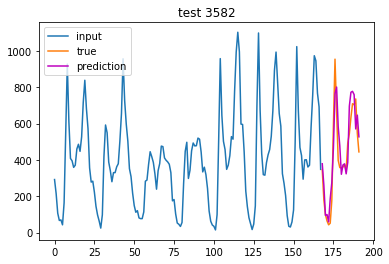

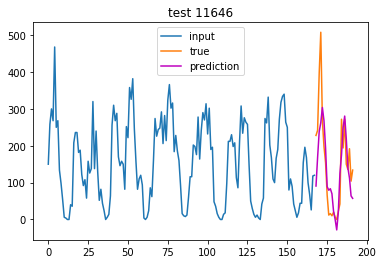

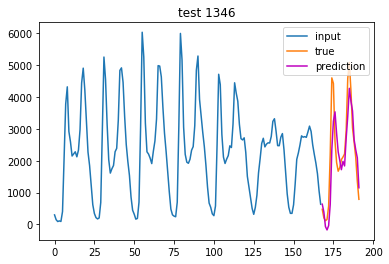

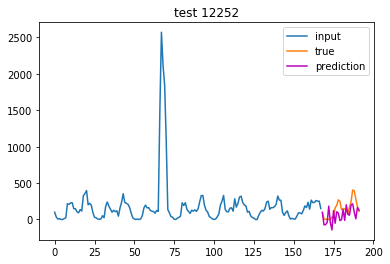

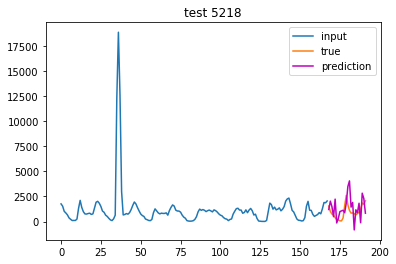

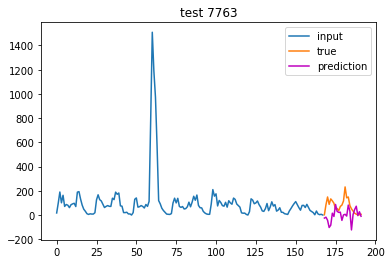

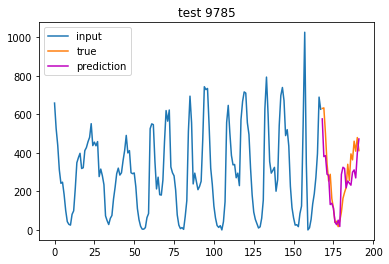

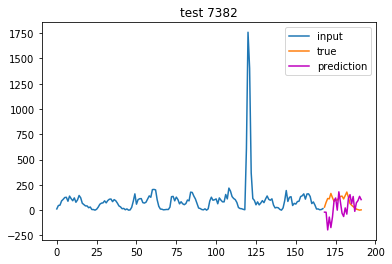

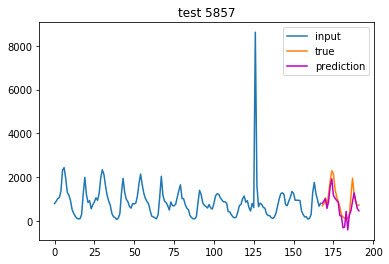

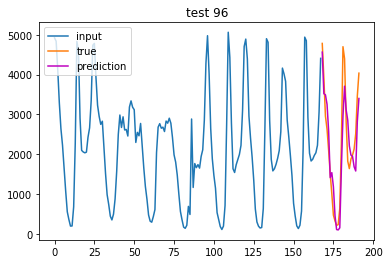

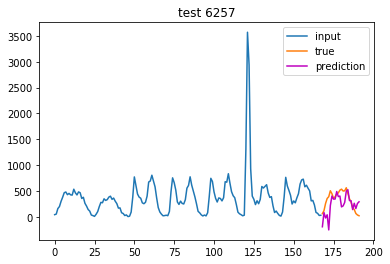

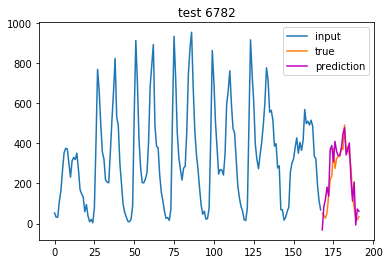

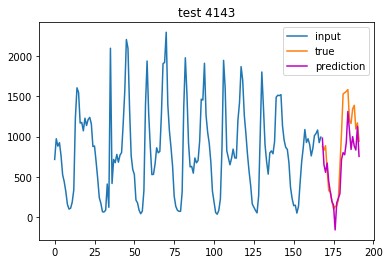

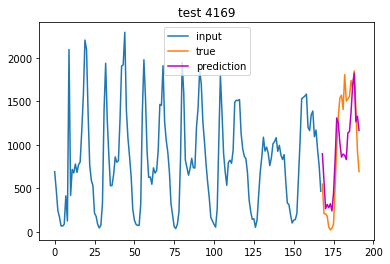

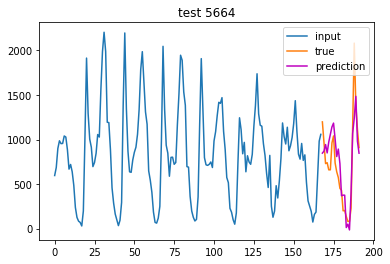

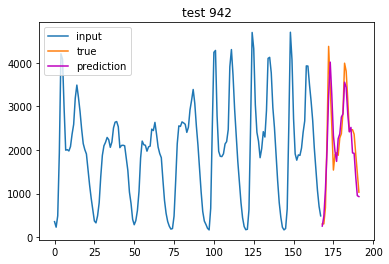

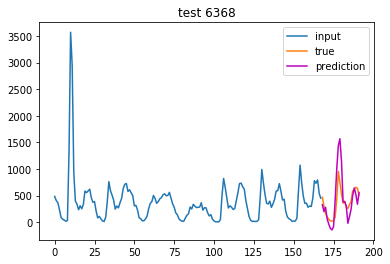

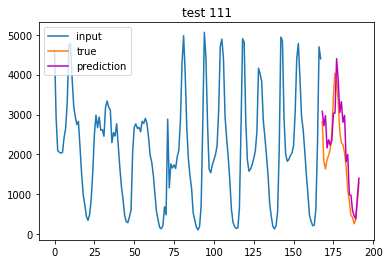

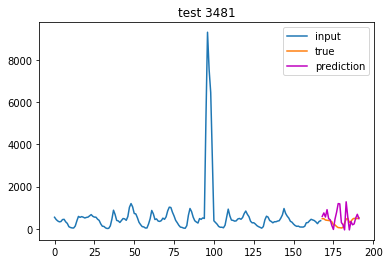

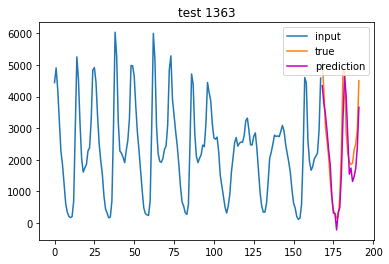

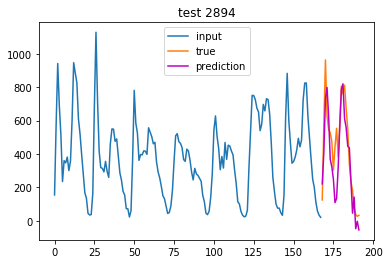

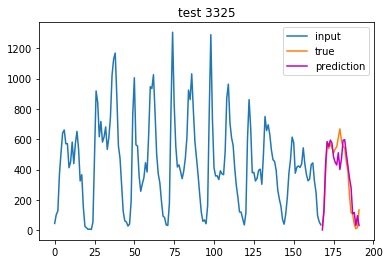

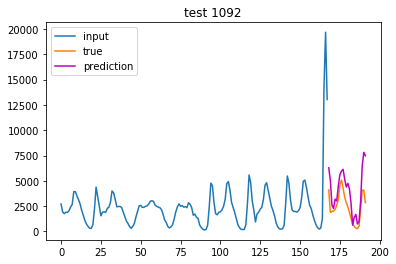

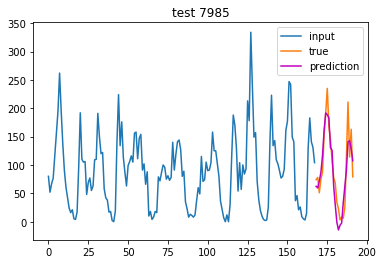

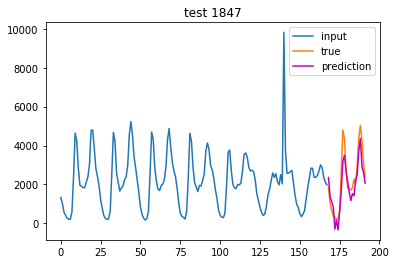

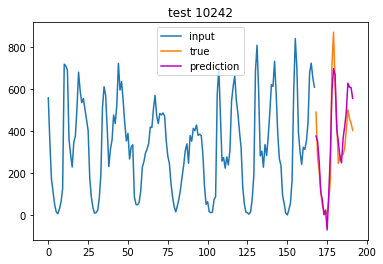

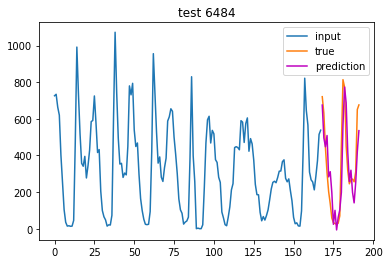

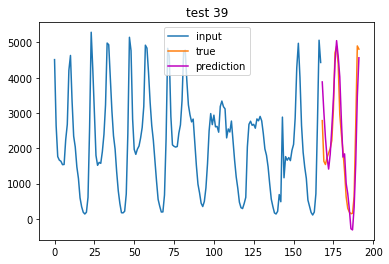

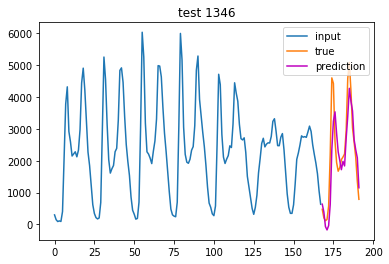

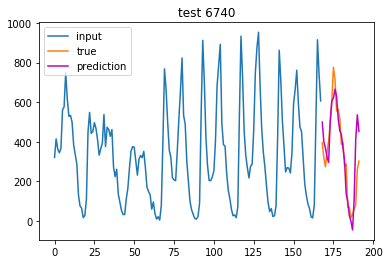

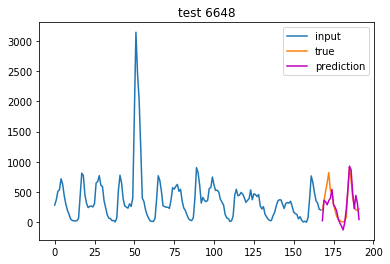

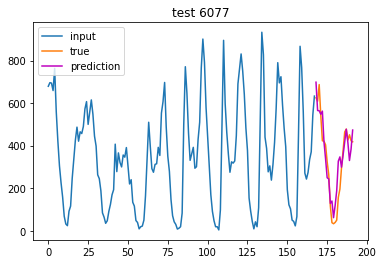

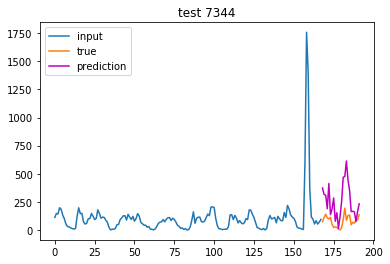

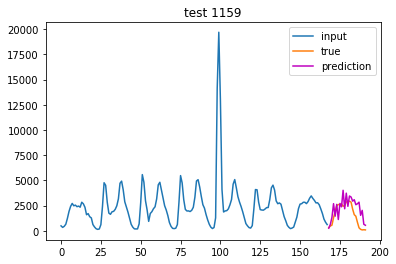

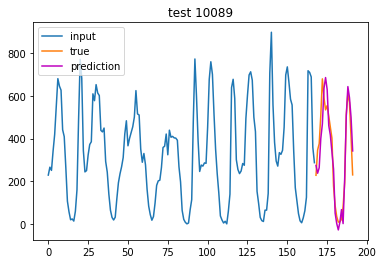

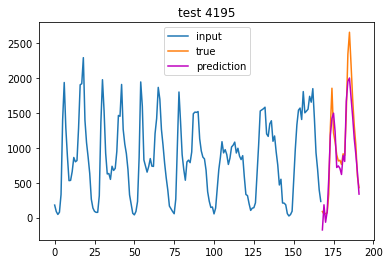

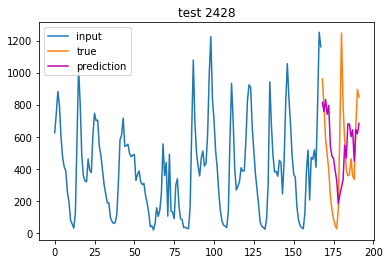

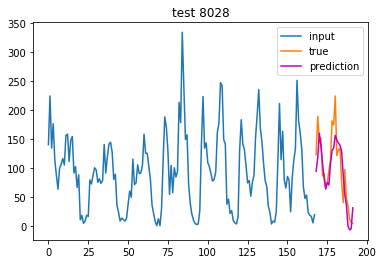

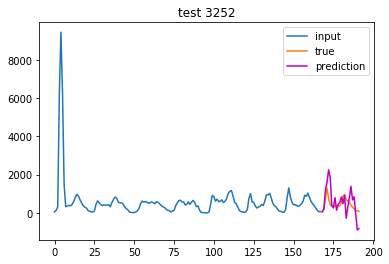

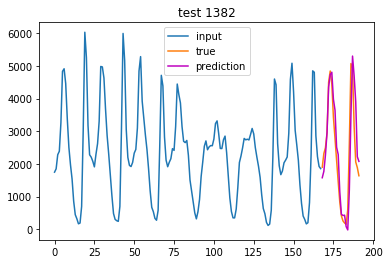

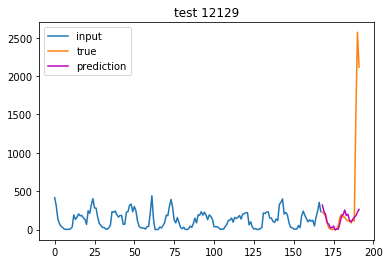

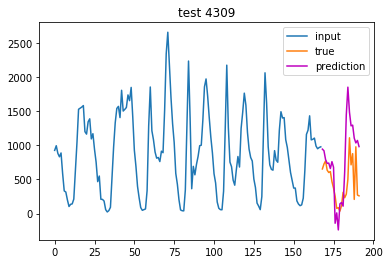

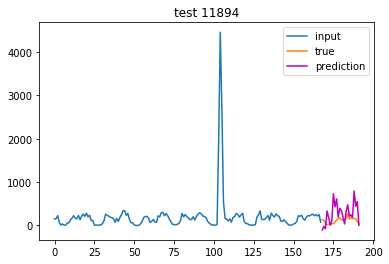

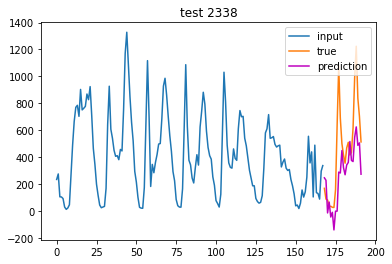

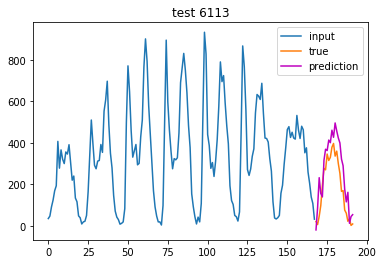

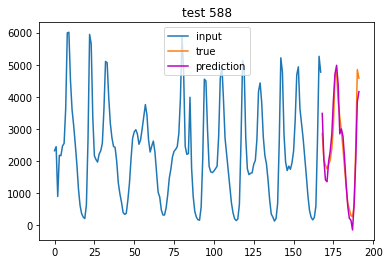

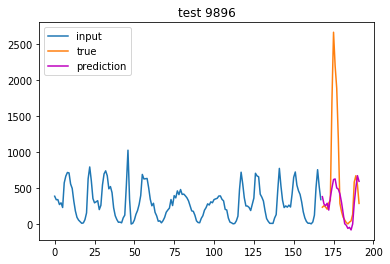

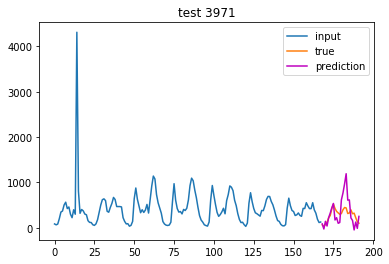

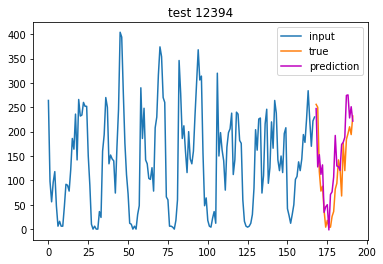

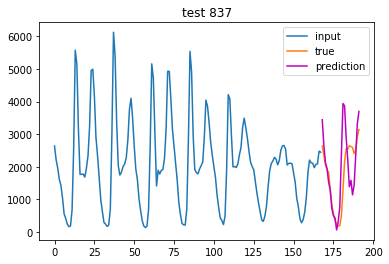

In [137]:
plt.rcParams.update({'figure.max_open_warning': 50})
np.random.seed(seed=123)
pred = model.predict(test_x)
pred = inverse_norm(pred.T, scaler=scaler_test).T
for i in np.random.randint(0, test_x.shape[0], 50):
    plt.figure()
    plt.plot(range(train_size), test_x_original[i], label='input')
    plt.plot(range(train_size, train_size+test_size), test_y_original[i], label='true')
    plt.plot(range(train_size, train_size+test_size), pred[i], c='m', label='prediction')
    plt.title(f'test {i}')
    plt.legend()

### Let's check on the same data as in `V1 ['Meas 5']`

#### Last result:

In [138]:
naive_prediction_mae(x_test=test_x_original, y_test=test_y_original)
model_mae(model, x_test=test_x, y_test=test_y_original,
          scaler=scaler_test, inv_norm=True)


naive model = 488.7186
current model = 254.3647


In [139]:
n = int(1998)
naive_prediction_mae(x_test=test_x_original[:n,:], y_test=test_y_original[:n,:])
model_mae_n(model, x_test=test_x, y_test=test_y_original[:n,:],
          scaler=scaler_test, n=n, inv_norm=True)


naive model = 1538.0077
current model = 623.6840


## Summary


### The results when we train  on 3 files (v1, v2, v4) X 3 columns:

```
naive model = 1538.0077
current model = 623.6840
```



### The results when we train on 3 columns:
```
naive model = 1538.0077
current model = 642.0665
```


### The results when we train only on 1 column:

```
naive model = 1538.0077
current model = 721.9249
```



In [141]:
(721-623)/623, (721-642)/642, (642-623)/623

(0.15730337078651685, 0.12305295950155763, 0.030497592295345103)

In [11]:
a, b, c = np.random.randn(10,3), np.random.randn(10,3), np.random.randn(10,3)


In [13]:
np.concatenate([a, b, c]).shape

(30, 3)

In [29]:
for key in x:
    print(type(key))

<class 'str'>


In [14]:
x = {'a': 1}

In [26]:
x['a']

1